<a href="https://colab.research.google.com/github/itzahs/CNN-RS/blob/main/Weights_BigEarthNet_BatchSize_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


## Get the dataset

In [ ]:
! pip install -qU tensorflow_datasets

     |████████████████████████████████| 4.0 MB 10.2 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
import tensorflow_datasets as tfds

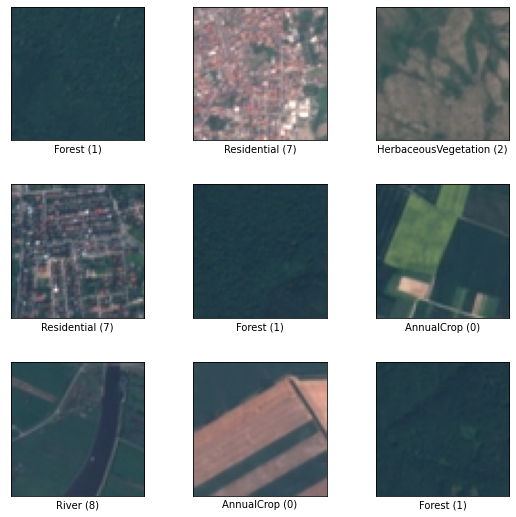

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks"


(train, val, test), ds_info = tfds.load("eurosat/rgb", 
                               with_info=True,
                               split=["train[:60%]", "train[60%:70%]", "train[70%:]"],
                               data_dir=DATA_DIR)
                               
tfds.show_examples(train, ds_info);

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='/content/drive/MyDrive/Colab Notebooks/IGARSS/RGB/eurosat/rgb/2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    su

## Exploring the dataset



In [ ]:
ds_info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [ ]:
class_names = []
for i in range(ds_info.features["label"].num_classes):
  class_names.append(ds_info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
#This dataset contains only one split train with 27000 images with 10 classes
list(ds_info.splits.keys())

['train']

In [ ]:
#The data is in a dictionary with three keys: 'filename', 'image(as array)' and the 'label' 
datapoint = next(iter(train)) #iterating over the dataset
datapoint

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'Forest_687.jpg'>,
 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
 array([[[35, 59, 71],
         [35, 59, 71],
         [36, 60, 72],
         ...,
         [32, 60, 72],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[35, 59, 71],
         [34, 61, 72],
         [37, 61, 73],
         ...,
         [31, 59, 70],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[37, 64, 73],
         [35, 64, 72],
         [38, 65, 74],
         ...,
         [35, 63, 74],
         [31, 59, 70],
         [32, 61, 69]],
 
        ...,
 
        [[31, 54, 70],
         [29, 55, 68],
         [32, 59, 70],
         ...,
         [33, 62, 70],
         [32, 60, 71],
         [34, 62, 73]],
 
        [[33, 59, 72],
         [32, 59, 70],
         [32, 59, 70],
         ...,
         [32, 60, 71],
         [37, 66, 74],
         [35, 65, 73]],
 
        [[34, 62, 73],
         [33, 61, 72],
         [35, 62, 73],
     

## Plot some images

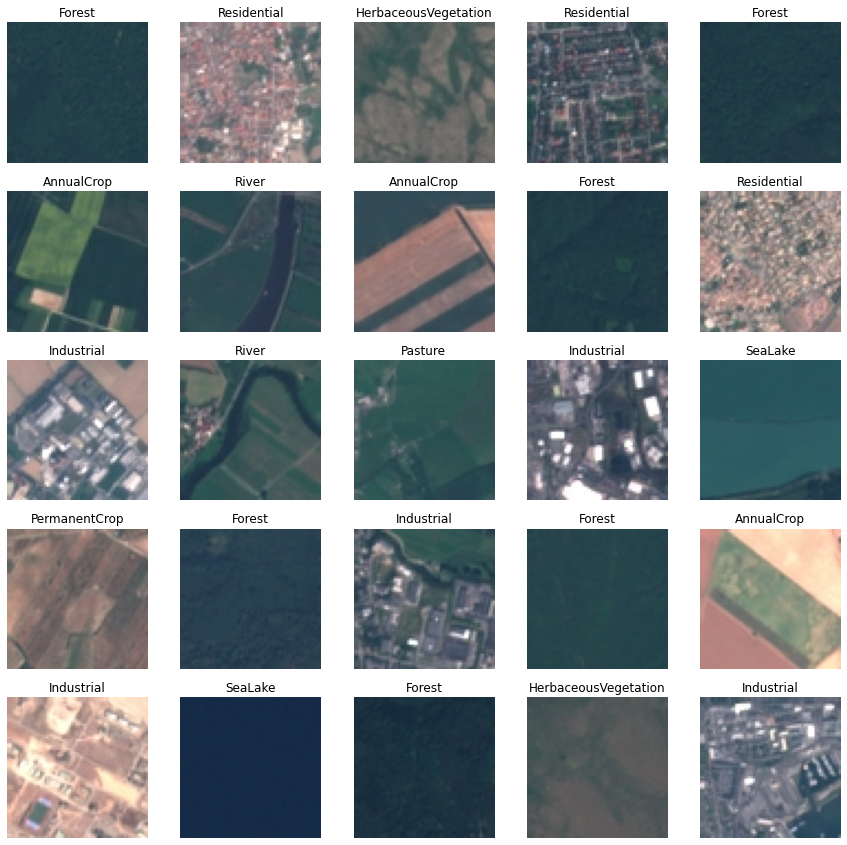

In [ ]:
#Each value of the key is a tensor and the numpy attributes of each tensor can be extracted with tfds.as_numpy()
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()


## Parameters configuration and data preprocessing

In [ ]:
#Folder to save the best model
FILE_MODEL = "/content/drive/MyDrive/Colab Notebooks/Resnet50BigEarthNetRGB128.hdf5"

#Define main variables
NUM_EPOCHS = 100
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [224, 224, 3]
NUM_CLASSES = ds_info.features["label"].num_classes

#As the dataset is batched is better to initialize:
STEPS_PER_EPOCH = int(ds_info.splits["train"].num_examples * 0.6)//BATCH_SIZE
VALIDATION_STEPS = int(ds_info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [ ]:
def data_preprocessing(datapoint):
  input_image = tf.image.resize(datapoint["image"], size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1]]) #Size must be 1D-tensor of two elements: width and height
  
  input_image = input_image/255           #Normalize uint8 values between 0 and 1
      
  return input_image, datapoint["label"]

In [ ]:
#Prepare data
train_dataset = train.map(data_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE) #num_parallel_call is used for number of processors
validation_dataset = val.map(data_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test.map(data_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#Batch the data and use caching & prefetching to optimize loading speed
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
#The data is in a dictionary with three keys: 'filename', 'image(as array)' and the 'label' 
datapoint = next(iter(train_dataset)) #iterating over the dataset
datapoint

(<tf.Tensor: shape=(128, 224, 224, 3), dtype=float32, numpy=
 array([[[[1.        , 0.7764706 , 0.6901961 ],
          [1.        , 0.7764706 , 0.6901961 ],
          [0.997479  , 0.7764706 , 0.6885154 ],
          ...,
          [0.5803922 , 0.505042  , 0.47759107],
          [0.5803922 , 0.5058824 , 0.47843137],
          [0.5803922 , 0.5058824 , 0.47843137]],
 
         [[1.        , 0.7764706 , 0.6901961 ],
          [1.        , 0.7764706 , 0.6901961 ],
          [0.997479  , 0.7764706 , 0.6885154 ],
          ...,
          [0.5803922 , 0.505042  , 0.47759107],
          [0.5803922 , 0.5058824 , 0.47843137],
          [0.5803922 , 0.5058824 , 0.47843137]],
 
         [[1.        , 0.7773109 , 0.69187677],
          [1.        , 0.7773109 , 0.69187677],
          [0.9980192 , 0.7778511 , 0.6905562 ],
          ...,
          [0.58075225, 0.5042017 , 0.47525012],
          [0.5803922 , 0.505042  , 0.47591037],
          [0.5803922 , 0.505042  , 0.47591037]],
 
         ...,
 
     

##Pre-trained models for image classification


### Import, build and compile the model (ResNet50)


In [ ]:
#ResNet50

#Load main libraries
import tensorflow as tf             
import tensorflow_hub as hub                    #saved models in tf hub
from tensorflow.keras import layers

#Import ResNet50 pre-trained on BigEarthNet
hub_url = "https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1"  
hub_layer = hub.KerasLayer(hub_url, input_shape=IMAGE_SHAPE, trainable=False)

#Keras API to build last layer and the final model
model_resnet = tf.keras.Sequential([
                                    hub_layer,  
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_resnet.build((None, 224, 224, 3))
model_resnet.summary()

#Compile, define loss, optimizers and metrics
#Labels are not one-hot encoded so we need to use sparse categorical cross-entropy
model_resnet.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23633899  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,688,117
Trainable params: 1,054,218
Non-trainable params: 23,633,899
_________________________________________________________________


In [ ]:
#Stop training and save the best model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath=FILE_MODEL, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, min_delta=1e-6,verbose=True, mode='min')
]

### Train the model

In [ ]:
#Train the models [ResNet]
history_res = model_resnet.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    callbacks = callback,
    validation_data = validation_dataset,
    validation_steps = VALIDATION_STEPS
)

Epoch 1/100
126/126 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.8293
Epoch 00001: val_accuracy improved from -inf to 0.89360, saving model to /content/drive/MyDrive/Colab Notebooks/IGARSS/Best_Models/Resnet50BigEarthNetRGB.hdf5
126/126 [==============================] - 42s 247ms/step - loss: 0.5128 - accuracy: 0.8293 - val_loss: 0.3040 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 2/100
126/126 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9154
Epoch 00002: val_accuracy improved from 0.89360 to 0.92336, saving model to /content/drive/MyDrive/Colab Notebooks/IGARSS/Best_Models/Resnet50BigEarthNetRGB.hdf5
126/126 [==============================] - 30s 237ms/step - loss: 0.2489 - accuracy: 0.9154 - val_loss: 0.2179 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 3/100
126/126 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9362
Epoch 00003: val_accuracy improved from 0.92336 to 0.93490, saving model to /content/drive/MyD

##Evaluating the results 


1.   Metrics
2.   Perform classification



In [ ]:
def visualizacion_resultados(history):
  epochs = [i for i in range(100)]                    #Change num of epochs
  fig, ax = plt.subplots(1, 2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(16, 9)

  ax[0].plot(epochs, train_acc, 'go-', label = 'Entrenamiento accuracy')
  ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation accuracy')
  ax[0].set_title('Entrenamiento & Validación accuracy')
  ax[0].legend()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  ax[1].plot(epochs, train_loss, 'go-', label = 'Entrenamiento loss')
  ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation loss')
  ax[1].set_title('Entrenamiento & Validación loss')
  ax[1].legend()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')

  plt.show()

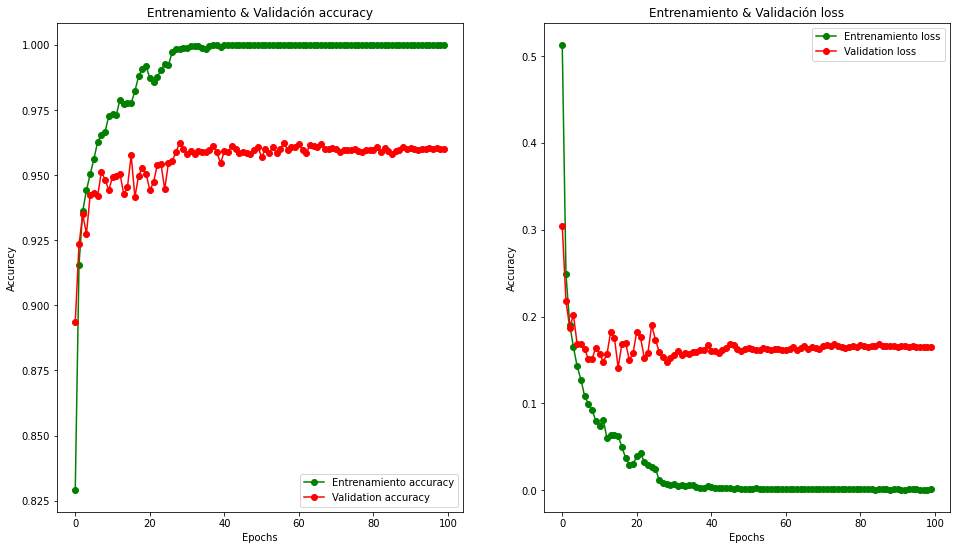

In [ ]:
#Metrics visualization
visualizacion_resultados(history_res)

In [ ]:
model_resnet.evaluate(test_dataset)

64/64 [==============================] - 12s 186ms/step - loss: 0.1729 - accuracy: 0.9593


[0.17285461723804474, 0.9592592716217041]

In [ ]:
#Perform a clasification
#plt.figure(figsize=(15, 15))
#for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
#  ax = plt.subplot(5, 5, i+1)
#  plt.imshow(datapoint["image"])
#  image = tf.image.resize(datapoint["image"], size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1]]) #Size must be 1D-tensor of two elements: width and height
#  image = preprocess_input(image)
#  image = np.expand_dims(image, axis=0)

#  if datapoint["label"] == np.argmax(model_resnet.predict(image)):
#    plt.title(class_names[np.argmax(model_resnet.predict(image))], color="green")
#  else:
#    plt.title(class_names[np.argmax(model_resnet.predict(image))], color="red")
#
#plt.show()

## Share results with tensorboard

In [ ]:
#Import main libraries
#from tensorflow.python.keras.callbacks import TensorBoard
#from time import time

In [ ]:
#Calling the model
#tensorboard_resnet = model_resnet

#Compiling the model
#tensorboard_resnet.compile(
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#    optimizer='adam',
#    metrics=['accuracy']
#)

#Configuring callbacks
#callback_tensorboard = TensorBoard(log_dir= 'logs/{}'.format(time()))

#Fit the model
#history_tbresnet = tensorboard_resnet.fit(
#    train_dataset,
#    epochs=NUM_EPOCHS,
#    steps_per_epoch = STEPS_PER_EPOCH,
#    callbacks = [callback_tensorboard],
#    validation_data = validation_dataset,
#    validation_steps = VALIDATION_STEPS
#)

In [ ]:
#Show tensorboard inline
#%load_ext tensorboard
#%tensorboard --logdir logs

In [ ]:
#Show tensorboard online
#!tensorboard dev upload --logdir ./logs --name "Transfer learning BigEarthNet-Eurosat" --description "Entrenamiento con ResNet50" --one_shot

# References

Codes adapted from:
1. CodeX For ML, 18 Sept. 2020, "How to use TensorFlow Datasets? Image classification with EuroSAT dataset with TFDS", [Video], YouTube, URL: https://www.youtube.com/watch?v=6th3rahsw9Y.
2. Vera, Adonaí. 1 Dec. 2021, “Curso Profesional De Redes Neuronales Con Tensorflow.” [E-Learning Website], URL: https://platzi.com/cursos/redes-neuronales-tensorflow/. 
3. Jens Leitloff and Felix M. Riese, "Examples for CNN training and classification on Sentinel-2 data", Zenodo, 10.5281/zenodo.3268451, 2018. [Repository], URL: https://github.com/jensleitloff/CNN-Sentinel


Tensorflow models and datasets:
1. Maxim Neumann, Andre Susano Pinto, Xiaohua Zhai,and Neil Houlsby,   “In-domain representation learningfor remote sensing,” Nov. 2019. URL: https://tfhub.dev/google/collections/remote_sensing/1